# Time Series Final Project

This report is based on the excel spreadsheet named "data_exam.xlsx".

_Authors: Sarra Ben Yahia & José Ángel García Sánchez_


### Library of used functions :


In [1]:
import pandas as pd
import numpy as np
import numpy.matlib
import warnings
warnings.filterwarnings("ignore")

# Time series analysis and modeling
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from statsmodels.tsa.api import VAR
from scipy.stats import multivariate_normal

# Probability distributions and statistical functions
from scipy.stats import norm

# Data visualization
import matplotlib.pyplot as plt

# Other libraries
from sklearn.linear_model import LinearRegression


In [2]:
def visualize_time_series(df):
    """
    Visualize each time series in the DataFrame.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        DataFrame containing the time series data to be visualized.

    Returns
    -------
    None
    """
    fig, axes = plt.subplots(nrows=len(df.columns),
                             ncols=1, dpi=120, figsize=(10, 6))
    for i, ax in enumerate(axes.flatten()):
        data = df[df.columns[i]]
        ax.plot(df.index, data, linewidth=1)
        # Decorations
        ax.set_title(df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
        plt.tight_layout()


In [3]:
def test_stationarity(df):
    """
    Perform ADF and KPSS tests on each column of the DataFrame
    """
    for col in df.columns:
        print(f'------------Testing column: {col}------------')

        # ADF test
        result_adf = adfuller(df[col])
        print('------------ ADF Statistic: %f' % result_adf[0])
        print('p-value: %f' % result_adf[1])
        for key, value in result_adf[4].items():
            print('Critical Value %s: %.3f' % (key, value))

        # KPSS test
        result_kpss = kpss(df[col])
        print('------------ KPSS Statistic: %f' % result_kpss[0])
        print('p-value: %f' % result_kpss[1])
        for key, value in result_kpss[3].items():
            print('Critical Value %s: %.3f' % (key, value))

        # Check if the time series is stationary or not
        if result_adf[1] < 0.05 and result_kpss[1] > 0.05:
            print("The time serie is stationary.")
        else:
            print("The time serie is not stationary.")

        print(' ' * 50)


In [4]:
def ML_HAR(para, x, plot=False):
    """
    Maximum likelihood function for HAR model optimization

    Parameters
    ----------
    para : array-like
        Array of HAR model parameters.
    x : pandas.core.series.Series
        Time series data to be fitted with the HAR model.
    plot : bool, optional
        If True, plot the time series data and the fitted values.

    Returns
    -------
    float
        Negative of the criterion function to be minimized by the optimization algorithm.
    """

    # Extract parameters
    phi0 = para[0]
    phi1 = para[1]
    phi2 = para[2]
    phi3 = para[3]

    # Computing moving averages
    ma5 = x.rolling(5).mean().shift(1)
    ma20 = x.rolling(20).mean().shift(1)
    ma1 = x.shift(1)

    # Combine the original series and the moving averages
    combination = pd.concat([x, ma1, ma5, ma20], axis=1)
    combination = np.log(combination)
    combination = combination.dropna()
    combination.columns = ['ini', 'ma1', 'ma5', 'ma20']

    # Calculate expected values using the HAR model
    expected = phi0 + phi1 * \
        combination['ma1'] + phi2 * combination['ma5'] + \
        phi3 * combination['ma20']

    # Combine the original series and the expected values
    temp = pd.concat([combination['ini'], expected], axis=1)

    # Calculate error and standard deviation of error
    error = combination['ini'] - expected
    sigma = np.nanstd(error)

    # Calculate density of error distribution
    density = norm.pdf(combination['ini'], expected, sigma)

    # Calculate criterion function to be minimized
    criterion = np.nansum(np.log(density))

    # Plot the data and the expected values if plot == True
    if plot == True:
        temp.plot()

    # Return the negative of the criterion function (to be minimized)
    return -criterion


In [5]:
def ML_HAR_fitted_values(para, x):
    """
    Returns the fitted values of a HAR model for a given set of parameters
    Args:
        para (list): A list of 4 parameters used to fit the model.
        x (pandas.DataFrame): A pandas DataFrame containing the time series data.
        plot (bool): Whether to plot the fitted values or not (default: False).
    Returns:
        pandas.DataFrame: A DataFrame containing the initial values of the time series and the fitted values.
    """

    # Extracting the parameters from the input list
    phi0 = para[0]
    phi1 = para[1]
    phi2 = para[2]
    phi3 = para[3]

    # Computing moving averages
    ma5 = x.rolling(5).mean().shift(1)
    ma20 = x.rolling(20).mean().shift(1)
    ma1 = x.shift(1)

    # Concatenating the moving averages into one DataFrame and taking the logarithm of the combination
    combination = pd.concat([x, ma1, ma5, ma20], axis=1)
    combination = np.log(combination)
    combination = combination.dropna()
    combination.columns = ['initial', 'ma1', 'ma5', 'ma20']

    # Computing the expected values using the input parameters and the logarithmic moving averages
    expected = phi0 + phi1 * \
        combination['ma1'] + phi2 * combination['ma5'] + \
        phi3 * combination['ma20']

    # Concatenating the initial values and the expected values into a DataFrame
    temp = pd.concat([combination['initial'], expected], axis=1)

    # Returning the initial values and the fitted values
    return temp[0]


In [6]:
def ar_order(ts, max_order):
    """
    Determine the order of an autoregressive (AR) model for a given time series based on maximum log-likelihood.

    Parameters:
    ts (pd.Series): Time series data
    max_order (int): Maximum order to consider for the AR model

    Returns:
    list: Log-likelihood values for each order from 1 to max_order
    """
    # Initialize an empty list to store log-likelihood values
    loglikelihood_values = []

    # Loop through all possible orders from 1 to max_order
    for order in range(1, max_order + 1):
        # Fit an AR model for the current order
        model = sm.AutoReg(ts, lags=order).fit()

        # Append the log-likelihood value of the fitted model to the list
        loglikelihood_values.append(model.llf)

    # Return the list of log-likelihood values
    return loglikelihood_values


In [7]:
def plot_acf_pacf(df):
    """
    Plots the ACF and PACF for each column of the input DataFrame.
    Args:
        df (pandas.DataFrame): The DataFrame containing the time series data.
    Returns:
        None.
    """
    for col in df.columns:
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
        plot_acf(df[col].dropna(), ax=ax[0])
        ax[0].set(title=f'ACF of {col}')
        plot_pacf(df[col].dropna(), ax=ax[1])
        ax[1].set(title=f'PACF of {col}')
        plt.show()


In [8]:
def ML_VAR(theta, X):
    """
    Calculates the log-likelihood of a VAR model.

    Parameters
    ----------
    theta : array-like
        Vector of model parameters.
    X : pandas.core.frame.DataFrame
        Matrix of time series data.

    Returns
    -------
    float
        Negative of the log-likelihood to be minimized by the optimization algorithm.
    """

    # Extract parameters from the theta vector
    Phi1 = [[theta[0], theta[1], theta[2]],
            [theta[3], theta[4], theta[5]],
            [theta[6], theta[7], theta[8]]]
    Phi0 = [[theta[9], theta[10], theta[11]]]

    # Create lagged data matrices Y and Z
    Y = X.iloc[1:X.shape[0], :]
    Z = X.iloc[0:X.shape[0] - 1, :]

    # Compute predicted values based on parameters
    Phi0_temp = np.matlib.repmat(Phi0, Z.shape[0], 1)
    temp = np.matmul(Z, Phi1) - Phi0_temp

    # Compute residuals and log-likelihood
    res = np.subtract(Y, temp)
    loglik = multivariate_normal.logpdf(
        res, mean=[0, 0, 0], cov=np.identity(3))
    loglik = -np.sum(loglik)

    return loglik


In [9]:
import numpy as np


def compute_aic_bic(loglik, n_params, n_obs):
    """
    Calculates the AIC and BIC given the absolute value of the log-likelihood, 
    the number of parameters in the model and the number of observations.

    Parameters
    ----------
    loglik : float
        The absolute value of the log-likelihood of the model.
    n_params : int
        The number of parameters in the model.
    n_obs : int
        The number of observations in the time series.

    Returns
    -------
    aic : float
        The Akaike Information Criterion (AIC) value.
    bic : float
        The Bayesian Information Criterion (BIC) value.
    """

    # Calculer la valeur absolue de la log-vraisemblance
    abs_loglik = abs(loglik)

    # Calculer l'AIC et le BIC
    aic = 2 * n_params - 2 * abs_loglik
    bic = np.log(n_obs) * n_params - 2 * abs_loglik

    return aic, bic


In [10]:
def test_autocorrelation(residuals, names=None):
    """
    This function uses the Durbin-Watson test to detect autocorrelation in residuals.

    Parameters
    ----------
    residuals : pandas.DataFrame or list of pandas.Series
        The residuals of the models for which you want to perform the test.

    If a list of pandas.Series is used, column names should be provided in names.
    names : list of str, optional (default None)
        The column names for the residuals, used for result display.

    Must be provided if residuals is a list of pandas.Series.

    Returns
    ----------
    pandas.DataFrame
    A DataFrame containing the results of the Durbin-Watson test for each column of residuals.
    """
    if isinstance(residuals, pd.DataFrame):
        names = residuals.columns
        residuals = [residuals[col] for col in names]

    results = []
    for resid, name in zip(residuals, names):
        dw = durbin_watson(resid)
        if dw < 1.5:
            result = "Positive auto-correlation"
        elif dw > 2.5:
            result = "Negative auto-correlation"
        else:
            result = "No auto-correlation"
        results.append(result)

    return pd.DataFrame({"Durbin-Watson Test Results": results}, index=names)


In [11]:
df = pd.read_excel("./data_exam.xlsx", index_col=0)
df.describe()


,VIX,Parkinson,Squared returns
count,5822.000000,5822.000000,5822.000000
mean,20.191311,0.000156,0.000145
std,8.674953,0.000575,0.000342
min,9.140000,0.000000,0.000001
25%,13.970000,0.000005,0.000026
50%,18.230000,0.000030,0.000061
75%,23.930000,0.000120,0.000138
max,82.690000,0.019919,0.006161


# 1. Explain the concept behind each column. What are these time series meant to represent? Trans- form these time series so that they are comparable in scale and order.


#### Introduction

In this report, we will analyze the joint relationship between three time series: parkinson and VIX estimators with squared returns. To better understand this relationship, we will convert all series to annual variances, as variances are closely linked to squared returns. In contrast, volatilities have a natural relationship with absolute returns.

#### Why Use Parkinson and VIX Estimators to Explain Squared Returns?

The estimated historical volatility $\sigma$ of returns only captures linear relationships and assumes all events are equally weighted. In financial markets, volatility estimates based on a small dataset might lead to noisy measurements of the estimator due to sampling errors. Conversely, a large dataset uses information that is no longer relevant to the present state of the market. Therefore, using historical volatility as an exact number may not represent the actual value.

To address this problem, alternative volatility estimators that use all data points other than closing prices, such as Close-to-Close, Garman and Klass (GK), Parkinson’s, Rogers and Satchell (RS), and Garman and Klass–Yang and Zhang (GK-YZ), can be used. In this report, we will focus on Parkinson and VIX estimators.

The Parkinson estimator is based on the high and low prices, while the VIX estimator is based on the implied volatilities of S&P 500 index options. By comparing their relation wiyh squared returns, we can gain insights into the joint relationship between these time series.

#### Parkinson estimator

The Parkinson estimator is widely used to transform squared returns from a daily to an intraday frequency. As we learned in class, having intraday series can be extremely expensive, often costing up to 10k€ per series. Thus, a good approach is to use the Parkinson estimator to approximate intraday returns and obtain a well-explained variability of returns. Then prooving the joint relation between Parkinson and Sqaured returns is essential.

The Parkinson estimator is a simplified version of the Garman Klass method, which includes a time component between the opening and closing prices. However, the Parkinson estimator is known for its high volatility, which can make it difficult to distinguish the signal from the noise. This is why we are going to cut this noise in the following steps of this report. It is necessary to filter out the white noise from the information provided by the estimator. The Parkinson estimator can be expressed as follows:

$$\sigma_{Parkinson} = \sqrt{\frac{1}{4n\ln2}\sum_{k=1}^n\left(\log\left(\frac{H_{k}}{L_{k}}\right)\right)^2}$$

#### Extension of parkinson estimator

Even if the Parkinson estimate of variance is unbiased for continuous prices, prices are only sampled discretely. Then another approach or extension to using the Parkinson estimator could be to consider more accurate volatility estimators. According to [volatilites mesures article](https://www.mdpi.com/1099-4300/24/10/1410), while the Parkinson estimator is five times more efficient than the close-to-close estimator, the Garman Klass method is 7.4 times more efficient than close-to-close. Garman-Klass estimator (GK) is given by:

$$\sigma_{GK} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\frac{1}{2}\left(\frac{\Delta H_i}{C_i} - \frac{\Delta L_i}{C_i}\right)^2 - (2\ln2 - 1)\left(\frac{\Delta C_i}{C_i}\right)^2\right)}$$

Moreover, an even more recent and improved version of the Garman Klass method is the Yang and Zhang developed version of GK (YZ-GK estimator), which provides even better accuracy and efficiency. The estimator is given by:

$$\sigma_{YZ-GK} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\alpha\left(\frac{\Delta H_i}{C_i}\right)^2 + (1-\alpha)\left(\frac{\Delta C_i}{C_i}\right)^2 - 2\beta\left(\frac{\Delta H_i}{C_i}\right)\left(\frac{\Delta C_i}{C_i}\right)\right)}$$

#### Parkison transformation

To annualize the Parkinson variance, we can multiply the daily variance by 252, since there are 252 trading days in a year. This transformation is given by the following formula:

$$\sigma_{Annualised\ Parkinson}^2 = \sigma_{Daily\ Parkinson}^2 * 252$$

#### VIX

The VIX (CBOE Volatility Index) is a measure of the expected 30-day volatility of the U.S. stock market, derived from the prices of S&P 500 index options. It represents the market's expectation of near-term volatility. In our case VIX is expressed as percentage points.

#####  VIX transformations  
To yield volatility from percentage value we do:

$$\sigma_{VIX} = \frac{VIX\ Value}{100}$$

then to have annualised variance we do:
$$\sigma_{Annualised\ VIX}^2 = \sigma_{VIX}*\left(\sqrt{\frac{252}{30}}\right)^2$$

#### Squared returns

Squared returns are a proxy for variance on returns while absolute returns are a proxy for volatility. According to the efficient market hypothesis, returns themselves are not autocorrelated. However, squared returns exhibit autocorrelation, revealing clusters of volatility. This clustering implies that periods of low variance tend to be followed by more low-variance periods, and similarly, high-variance periods tend to precede other high-variance periods. Additionally, there is a negative relationship between returns and volatility, a phenomenon known as the leverage effect.

##### The significance of the second moment

In line with the efficient market hypothesis, the first moment is considered to be zero. If a trend were easily exploitable, market participants would seize the opportunity, causing prices to rise and subsequently rendering the first moment null. The second moment, on the other hand, presents a potential for profit. By accurately modeling the second moment, investors can gain a financial advantage. In addition, literature has proposed several approaches that involve normalizing the data series and subsequently examining the third and fourth moments.


In [12]:
df_annualised = pd.DataFrame({
    'VIX_variance': ((df['VIX'] / 100) * np.sqrt(252/30))**2,
    'parkinson_variance': df['Parkinson'] * 252,
    'squared_returns': df['Squared returns'] * 252
})


In [13]:
df_diff = df_annualised.diff().dropna()
df_diff.columns = [f"{col}_diff" for col in df_annualised.columns]


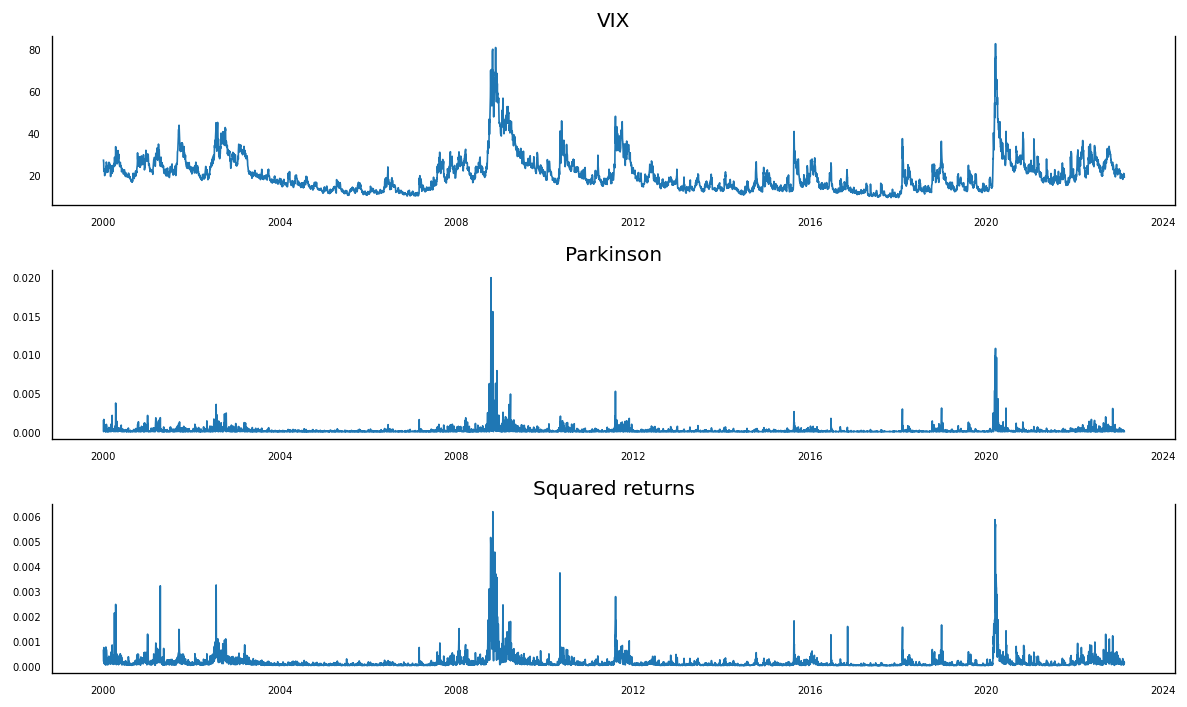

In [14]:
visualize_time_series(df)


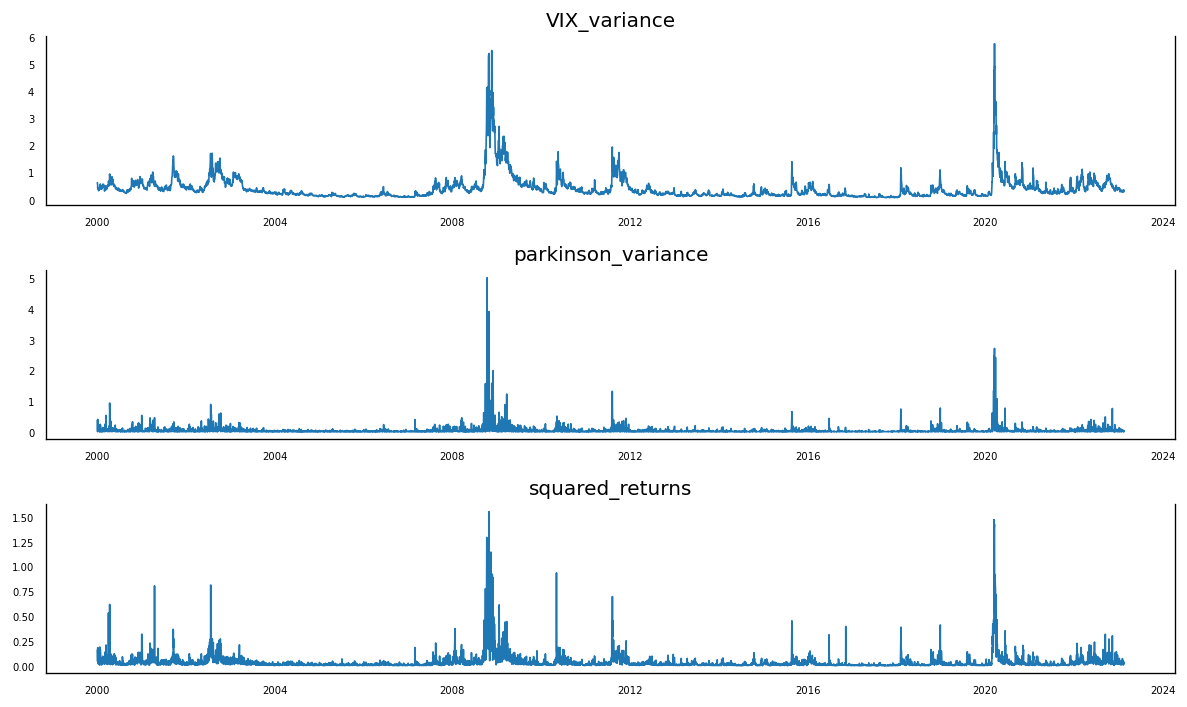

In [15]:
visualize_time_series(df_annualised)


# 2. Estimate an AR model on each of these time series. Determine the order of the AR process and show the estimates. What can you conclude from these estimations? (2 points)


In [16]:
# Selecting the annualised time series
vix, parkinson, squared_returns = df_annualised[[
    'VIX_variance', 'parkinson_variance', 'squared_returns']].values.T


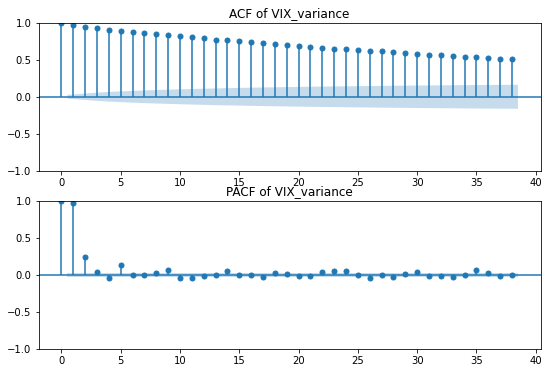

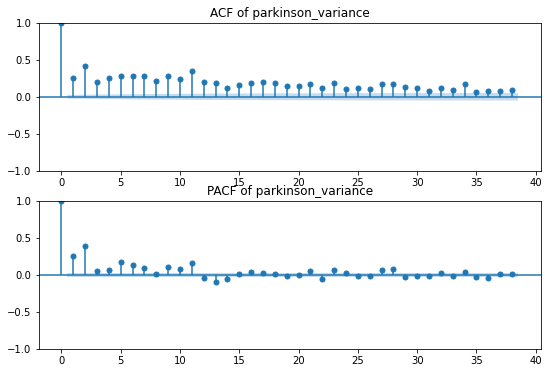

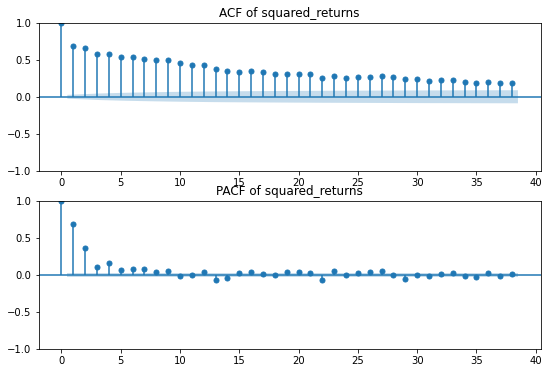

In [17]:
plot_acf_pacf(df_annualised)


As we cannot model an AR without confirming the stationarity of our time series, we verify if the series are or not stationary with two test: ADF and KPSS.

The ADF test is used to test for the presence of a unit root in a time series. The test regression equation can be written as:

$$\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{k}\delta_i \Delta y_{t-i} + \epsilon_t$$

where $\Delta$ is the first difference operator, $y_t$ represents the time series data, $t$ is the time index, $k$ is the number of lags included in the test regression, and $\epsilon_t$ is the error term.

The KPSS test is used to test for stationarity in a time series. The test equation can be written as:

$$y_t = \mu + \beta t + \rho_t + \epsilon_t$$

where $\rho_t$ is a random walk component, defined as $\rho_t = \rho_{t-1} + u_t$, and $u_t$ is an i.i.d. sequence of error terms.

The test statistic for the KPSS test is given by:

$$\Lambda = \frac{\sum_{t=1}^T (\hat{\rho}_t)^2}{\hat{\sigma}^2_u}$$

where $\hat{\rho}_t$ is the cumulative sum of the estimated residuals, and $\hat{\sigma}^2_u$ is the consistent estimator of the long-run variance of the error terms.

In [18]:
warnings.filterwarnings("ignore")
test_stationarity(df_annualised)


------------Testing column: VIX_variance------------
------------ ADF Statistic: -6.091627
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.383261
p-value: 0.084370
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: parkinson_variance------------
------------ ADF Statistic: -8.185235
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.169003
p-value: 0.100000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: squared_returns------------
------------ ADF Statistic: -8.214812
p-value: 0.000000
Critical Value 1%: -3.431


The time series are stationary, we can proceed to the estimation of the AR model


In [19]:
import statsmodels.tsa.api as sm


# Determine the optimal order for each of the time series data using the ar_order function
# The ar_order function takes in a time series data and returns the log likelihood for different orders up to 5 because the
#  "weakly investors" have more important weights
vix_loglikelihood = ar_order(vix, 5)
parkinson_loglikelihood = ar_order(parkinson, 5)
squared_returns_loglikelihood = ar_order(squared_returns, 5)

# Determine the order with the highest log likelihood for each of the time series data
vix_order = np.argmax(vix_loglikelihood)
parkinson_order = np.argmax(parkinson_loglikelihood)
squared_returns_order = np.argmax(squared_returns_loglikelihood)

# Create the AR model for each of the time series data using the determined order and fit it to the data
vix_ar_model = sm.AutoReg(vix, lags=vix_order).fit()
parkinson_ar_model = sm.AutoReg(parkinson, lags=parkinson_order).fit()
squared_returns_ar_model = sm.AutoReg(
    squared_returns, lags=squared_returns_order).fit()

# Print the coefficients and log-likelihood for each of the AR models
print('------------VIX AR({}) model coefficients:------------'.format(vix_order))
print(vix_ar_model.params)
print('Log-Likelihood :', vix_loglikelihood[np.argmax(vix_loglikelihood)])
print('\n------------Parkinson AR({}) model coefficients:------------'.format(parkinson_order))
print(parkinson_ar_model.params)
print('Log-Likelihood :',
      parkinson_loglikelihood[np.argmax(parkinson_loglikelihood)])
print('\n------------Squared returns AR({}) model coefficients:------------'.format(squared_returns_order))
print(squared_returns_ar_model.params)
print('Log-Likelihood :',
      squared_returns_loglikelihood[np.argmax(squared_returns_loglikelihood)])


------------VIX AR(4) model coefficients:------------
[ 0.01142485  0.73403798  0.21322284  0.06859384 -0.04408225]
Log-Likelihood : 4256.701388796983

------------Parkinson AR(4) model coefficients:------------
[0.01609887 0.13344335 0.3508436  0.04263336 0.06149218]
Log-Likelihood : 3745.8928719813457

------------Squared returns AR(4) model coefficients:------------
[0.00562621 0.38712285 0.26641146 0.03288335 0.15911658]
Log-Likelihood : 8350.067469864667


In [20]:
# AR predictions
ar_models = [vix_ar_model, parkinson_ar_model, squared_returns_ar_model]
ar_preds = [model.predict() for model in ar_models]
vix_ar_pred, parkinson_ar_pred, squared_returns_ar_pred = ar_preds

# Residuals
ar_residues = [model.resid for model in ar_models]
vix_ar_resid, parkinson_ar_resid, squared_returns_ar_resid = ar_residues

# Log-likelihood
loglikelihood_vix_ar = abs(vix_ar_model.llf)
loglikelihood_parkinson_ar = abs(parkinson_ar_model.llf)
loglikelihood_squared_returns_ar = abs(squared_returns_ar_model.llf)

# AIC
aic_vix_ar = vix_ar_model.aic
aic_parkinson_ar = parkinson_ar_model.aic
aic_squared_returns_ar = squared_returns_ar_model.aic

# BIC
bic_vix_ar = vix_ar_model.bic
bic_parkinson_ar = parkinson_ar_model.bic
bic_squared_returns_ar = squared_returns_ar_model.bic


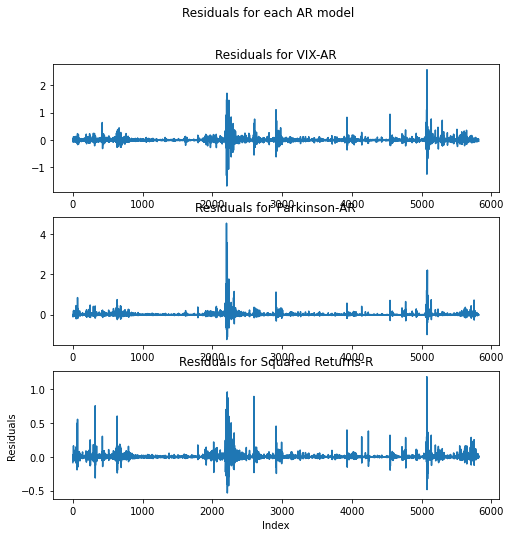

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(vix_ar_resid)
axs[0].set_title("Residuals for VIX-AR")
axs[1].plot(parkinson_ar_resid)
axs[1].set_title("Residuals for Parkinson-AR")
axs[2].plot(squared_returns_ar_resid)
axs[2].set_title("Residuals for Squared Returns-R")

fig.suptitle("Residuals for each AR model")
plt.xlabel("Index")
plt.ylabel("Residuals")

plt.show()


In [22]:
# test the autocorrelation of the residuals
residuals = [vix_ar_resid, parkinson_ar_resid, squared_returns_ar_resid]
residual_names = ["VIX", "Parkinson", "Squared Returns"]
test_autocorrelation(residuals, residual_names)


,Durbin-Watson Test Results
VIX,No auto-correlation
Parkinson,No auto-correlation
Squared Returns,No auto-correlation


When examining the autoregressive (AR) order, we encounter inconsistent results even if the residuals are not autocorrelated. Indeed, as we increase the order, we consistently find a larger order that maximizes the log-likelihood. This observation may be attributed to the clustering of volatilities. More recent literature, such as the Heterogeneous Autoregressive (HAR) model, addresses this issue by considering the second moment as time-varying. We expect that the HAR model will yield more precise and accurate results.

We have a lag order of 4. It seems logical. In fact, the litterature defines three types of investors: daily (speculators), weekly, and monthly. The most influential investors on the market are the weekly ones. Consequently, we hypothesize that an autocorrelation of approximately five days would be a realistic representation of the market's behavior.


# 3. Plot the fitted values for each model vs. the original time series. Why are these fitted values appealing for volatility measuring purposes? (2 points)


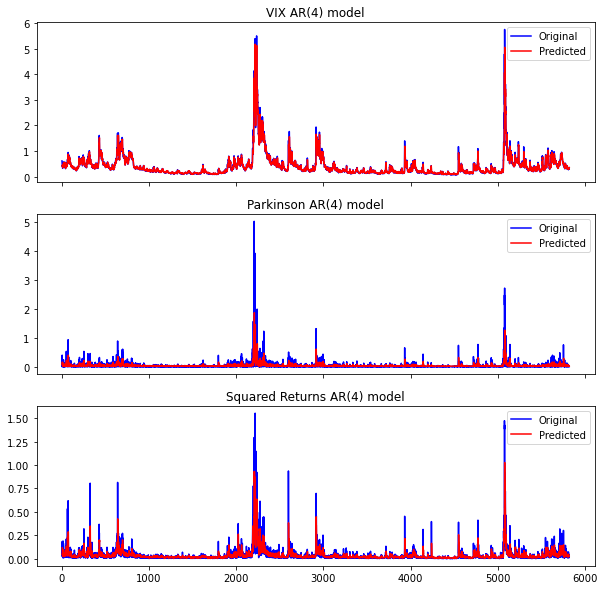

In [23]:
# Plot original time series and fitted values
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# VIX series
axes[0].plot(vix, color='blue', label='Original')
axes[0].plot(vix_ar_pred, color='red', label='Predicted')
axes[0].set_title('VIX series')
axes[0].set_title('VIX AR({}) model'.format(vix_order))
axes[0].set_xticklabels([])
axes[0].set_xticklabels([])
axes[0].legend()
axes[0].legend()

# Parkinson series
axes[1].plot(parkinson, color='blue', label='Original')
axes[1].plot(parkinson_ar_pred, color='red', label='Predicted')
axes[1].set_title('Parkinson series')
axes[1].set_title('Parkinson AR({}) model'.format(parkinson_order))
axes[1].set_xticklabels([])
axes[1].set_xticklabels([])
axes[1].legend()
axes[1].legend()

# Squared returns series
axes[2].plot(squared_returns, color='blue', label='Original')
axes[2].plot(squared_returns_ar_pred, color='red', label='Predicted')
axes[2].set_title('Squared Returns series')
axes[2].set_title('Squared Returns AR({}) model'.format(squared_returns_order))
axes[2].legend()
axes[2].legend()

plt.show()


Reminder: Volatility represents the second moments of returns and, due to market efficiency, are the only moments that are useful for investors to realize a gain.

Based on the plots, we can see that the AR models generally capture the overall direction of the time series data, although there are instances where the chosen order may not be appropriate. Despite this limitation, the information provided by the AR models can still be valuable for actors in the domains of risk management, trading and investment, portfolio management, and financial forecasting. By predicting future volatility levels, these actors can better assess and manage risk, make informed decisions, and allocate assets in a way that balances risk and return. Thus, even though the AR models may not perfectly capture the volatility patterns in the data, the insights provided can still be valuable for financial analysis and decision-making.


# 4. Estimate an HAR model on each time series. Present the estimated coefficients of the model and compare the loglikelihood of each model to the one obtained from the AR estimations. Which model do you prefer? (4 points). Retain the fitted values of the model you have selected for each of the three time series.


In [24]:
vix = df_annualised['VIX_variance']
parkinson = df_annualised['parkinson_variance']
squared_returns = df_annualised['squared_returns']


### VIX


In [25]:
# Optimize the parameters
x0 = np.array([-1, 1, 0.5, 2])
res_EV = minimize(ML_HAR, x0, method='BFGS', args=vix,
                  hess=True, options={'disp': True})


         Current function value: -3169.624755
         Iterations: 25
         Function evaluations: 327
         Gradient evaluations: 63


In [26]:
# Estimated coefficients
res_EV.x


array([-0.01749709,  0.891863  ,  0.05346456,  0.04148744])

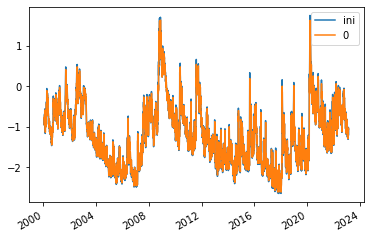

In [27]:
# Fit the optimized parameters and save the log likelihood, aic and bic
log_likelihood_vix_har = ML_HAR(res_EV.x, vix, True)
log_likelihood_vix_har = abs(log_likelihood_vix_har)
aic_vix_har, bic_vix_har = compute_aic_bic(
    log_likelihood_vix_har, len(res_EV.x), len(vix))


In [28]:
# Saving the fitted values
fitted_vix = ML_HAR_fitted_values(res_EV.x, vix)


### Parkinson


Before modeling with HAR, the Parkinson series needs to be preprocessed. This is because it is a highly volatile measure, making it difficult for models to make accurate estimates. To address this, the "white noise" part of the series needs to be separated and the relevant information selected.

To cut white noise in this series, we can use a smoothing technique like a moving average to smooth out the short-term fluctuations in the data and reveal the underlying trend. By doing so, we can improve our ability to analyze and model the variance, which can help us to better understand its progression.


In [29]:
# Choose a window size of 5
window_size = 5

# Apply a moving average to the series
moving_average = parkinson.rolling(window=window_size).mean()

# Replace the original series with the moving average
parkinson_smoothed = moving_average


In [30]:
x0 = np.array([1, .8, -1, 1])
res_EV = minimize(ML_HAR, x0, method='BFGS',
                  args=parkinson_smoothed, hess=True, options={'disp': True})


         Current function value: 4312.741984
         Iterations: 17
         Function evaluations: 301
         Gradient evaluations: 58


In [31]:
# Estimated coefficients
res_EV.x


array([-0.20910833,  0.91288114, -0.09009683,  0.13204269])

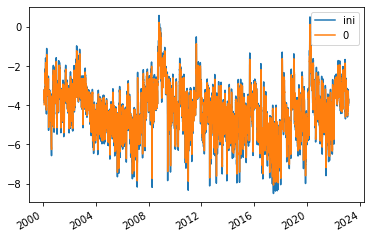

In [32]:
# Fit the optimized parameters and save the log likelihood, aic and bic
log_likelihood_parkinson_har = ML_HAR(res_EV.x, parkinson_smoothed, True)
log_likelihood_parkinson_har = abs(log_likelihood_parkinson_har)
aic_parkinson_har, bic_parkinson_har = compute_aic_bic(
    log_likelihood_parkinson_har, len(res_EV.x), len(parkinson_smoothed))


In [33]:
# Saving the fitted values
fitted_parkinson = ML_HAR_fitted_values(res_EV.x, parkinson_smoothed)


### Squared returns


In [34]:
x0 = np.array([1, .8, -1, 1])
res_EV = minimize(ML_HAR, x0, method='BFGS',
                  args=squared_returns, hess=True, options={'disp': True})


         Current function value: 6979.159745
         Iterations: 16
         Function evaluations: 130
         Gradient evaluations: 26


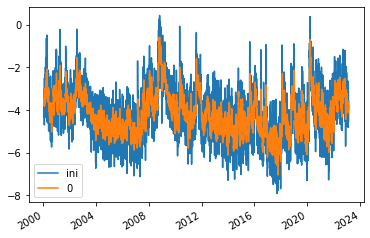

In [35]:
# Fit the optimized parameters and save the log likelihood, aic and bic
log_likelihood_squared_returns_har = ML_HAR(res_EV.x, squared_returns, True)
log_likelihood_squared_returns_har = abs(log_likelihood_squared_returns_har)
aic_squared_returns_har, bic_squared_returns_har = compute_aic_bic(
    log_likelihood_squared_returns_har, len(res_EV.x), len(squared_returns))


In [36]:
# Estimated coefficients
res_EV.x


array([-0.4980303 ,  0.15652778,  0.49154824,  0.27542057])

In [37]:
# Saving the fitted values
fitted_returns = ML_HAR_fitted_values(res_EV.x, squared_returns)


In [38]:
# Saving the fitted values of the HAR model into 1 df

df_har = pd.DataFrame()
df_har["vix"] = fitted_vix
df_har["parkinson"] = fitted_parkinson
df_har["squared_returns"] = fitted_returns
df_har.dropna(inplace=True)


In [39]:
# Here we have the log-likelihood, AIC and BIC summary for each time serie and each model

model_AR_summary = results_df = pd.DataFrame({
    'Série': ['vix', 'parkinson', 'squared_returns'],
    'AR - Log-vraisemblance': [loglikelihood_vix_ar, loglikelihood_parkinson_ar, loglikelihood_squared_returns_ar],
    'AR - AIC': [aic_vix_ar, aic_parkinson_ar, aic_squared_returns_ar],
    'AR - BIC': [bic_vix_ar, bic_parkinson_ar, bic_squared_returns_ar],
})


model_HAR_summary = results_df = pd.DataFrame({
    'Série': ['vix', 'parkinson', 'squared_returns'],
    'HAR - Log-vraisemblance': [log_likelihood_vix_har, log_likelihood_parkinson_har, log_likelihood_squared_returns_har],
    'HAR - AIC': [aic_vix_har, aic_parkinson_har, aic_squared_returns_har],
    'HAR - BIC': [bic_vix_har, bic_parkinson_har, bic_squared_returns_har],

})

display(model_AR_summary,
        model_HAR_summary)


,Série,AR - Log-vraisemblance,AR - AIC,AR - BIC
0,vix,4210.495719,-8408.991439,-8368.979168
1,parkinson,3656.415944,-7300.831887,-7260.819616
2,squared_returns,8340.196994,-16668.393987,-16628.381716


,Série,HAR - Log-vraisemblance,HAR - AIC,HAR - BIC
0,vix,3169.624755,-6331.249510,-6304.571913
1,parkinson,4312.741984,-8617.483967,-8590.806371
2,squared_returns,6979.159745,-13950.319490,-13923.641893


Looking at the results, we can see that for all time series, the log-likelihood values are higher for the AR models than for the HAR models. However, the AIC and BIC values are lower for the HAR models than for the AR models for all time series.

We have chosen to proceed with the HAR model, as it is better suited for handling data with heteroscedasticity and clustering in the variances. It is important to remember that the log-likelihood may be influenced by the number of parameters in each model. The AR model, with more parameters, could potentially yield a higher log-likelihood due to overfitting. As such, it is essential to consider additional model selection criteria, such as AIC or BIC, which account for the number of parameters and provide a more comprehensive evaluation of model performance.


# 5. Test for the stationnarity of the esimtated time series. Comment your results. (3 points)


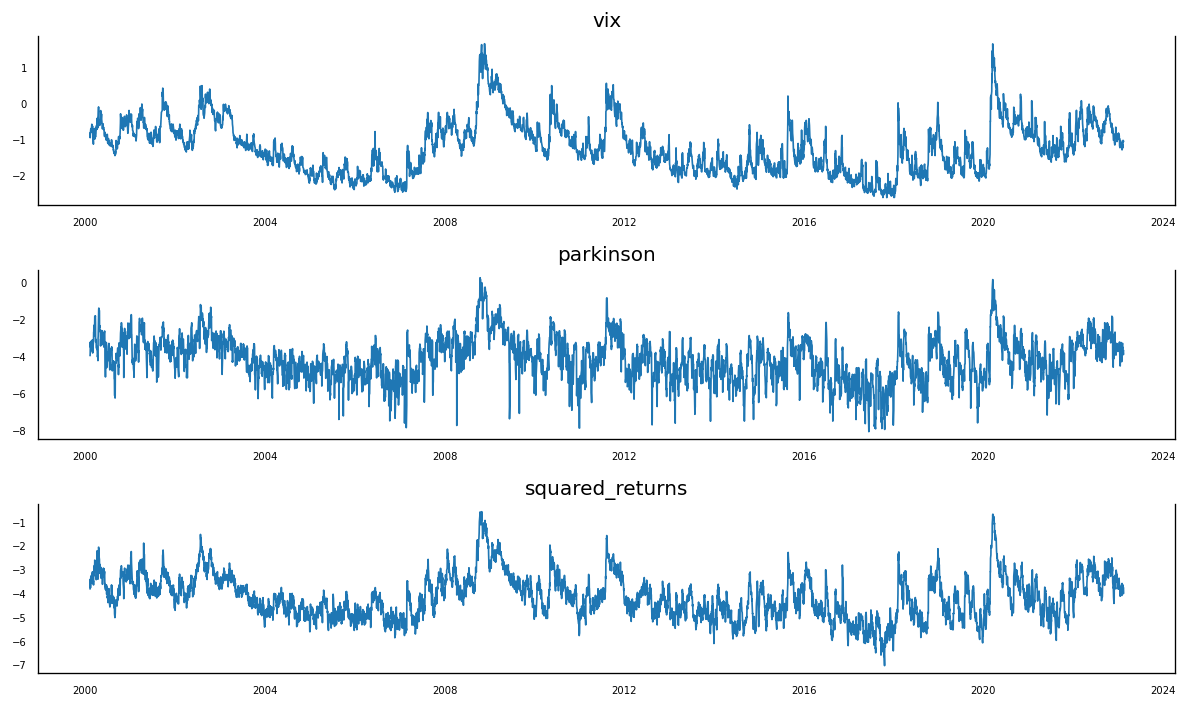

In [40]:
visualize_time_series(df_har)


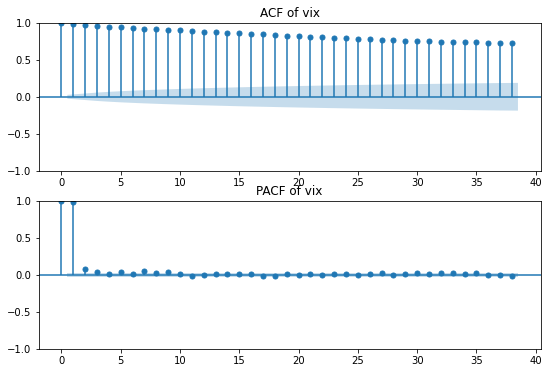

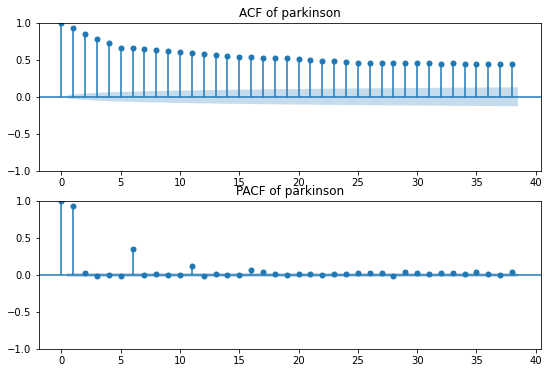

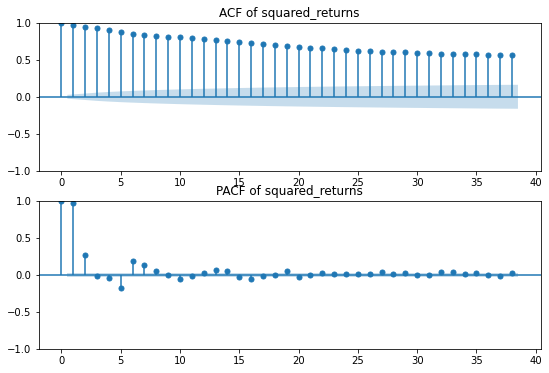

In [41]:
plot_acf_pacf(df_har)


In [42]:
warnings.filterwarnings("ignore")
test_stationarity(df_har)


------------Testing column: vix------------
------------ ADF Statistic: -5.040379
p-value: 0.000018
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.805255
p-value: 0.010000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is not stationary.
                                                  
------------Testing column: parkinson------------
------------ ADF Statistic: -5.584249
p-value: 0.000001
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.915223
p-value: 0.010000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is not stationary.
                                                  
------------Testing column: squared_returns------------
------------ ADF Statistic: -5.270351
p-value: 0.000006
Critical Value 1%: -3.431
Critical V

The non-stationarity in our estimated series may result from this snippet of the HAR model :

```
combination = pd.concat([x, ma1, ma5, ma20], axis=1)
combination = np.log(combination)
```

The log transformation applied during the HAR model construction. Although log transformation typically stabilizes variance and promotes stationarity, it can alter data patterns and potentially introduce non-stationarity in specific cases. In our situation, the original stationary series likely became non-stationary due to the transformation.


# 6. Estimate a VAR(p) model on your three stationnary fitted values. Comment your results. (4 points)


### Step 1 : Transforming the fitted values to be stationnary


In [43]:
# Differentiating the series to stationnarize them
df_har_stationnary = df_har.diff().dropna()


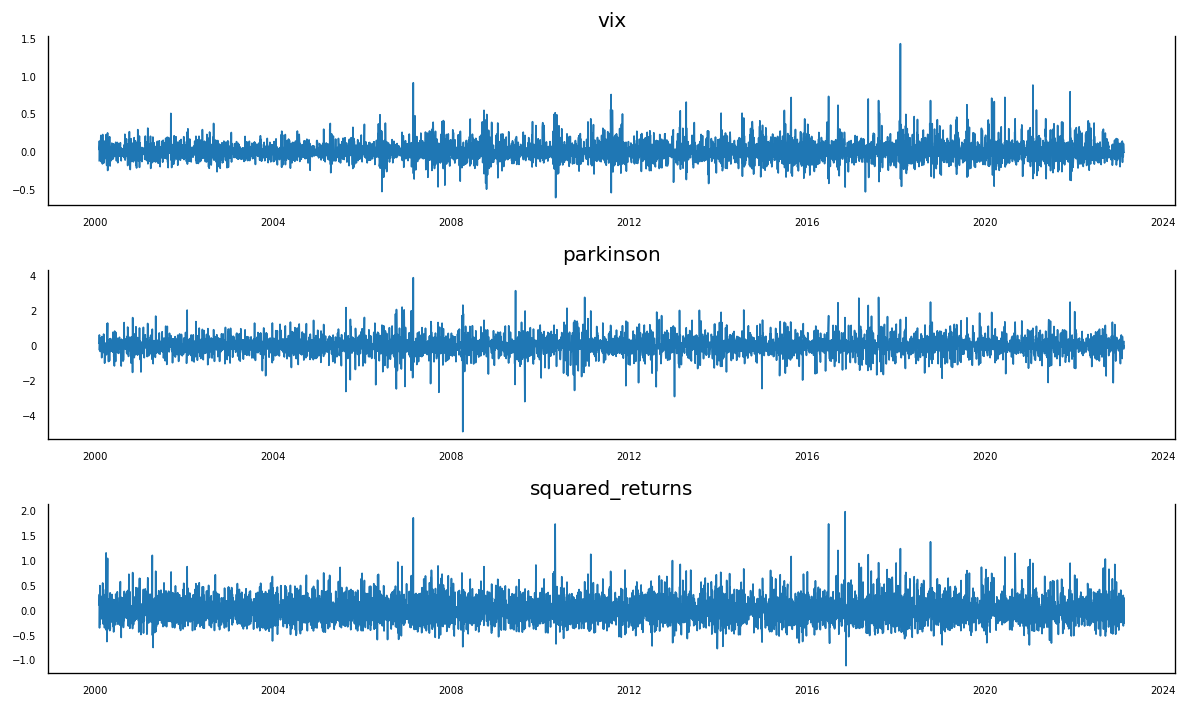

In [44]:
visualize_time_series(df_har_stationnary)


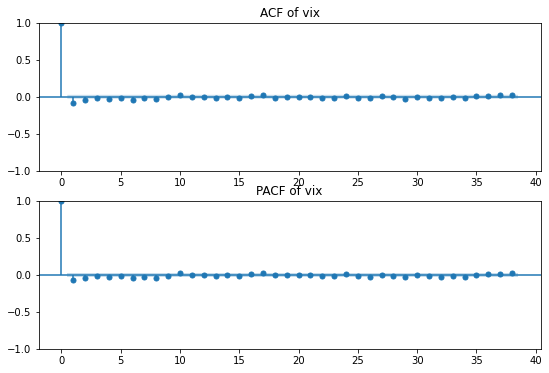

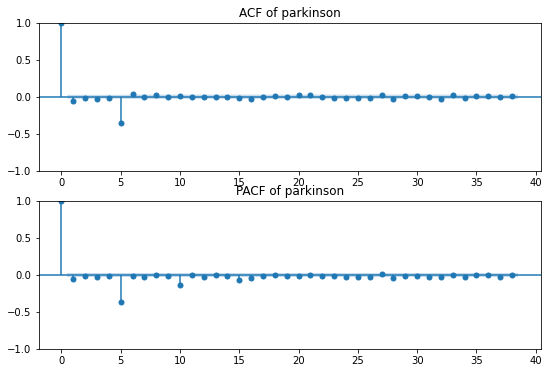

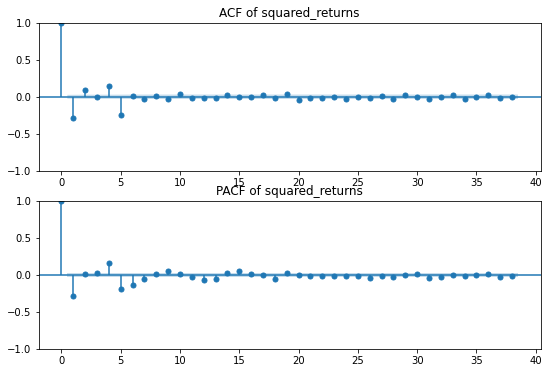

In [45]:
plot_acf_pacf(df_har_stationnary)


In [46]:
warnings.filterwarnings("ignore")
test_stationarity(df_har_stationnary)


------------Testing column: vix------------
------------ ADF Statistic: -31.365934
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.012951
p-value: 0.100000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: parkinson------------
------------ ADF Statistic: -19.149184
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 5%: -2.862
Critical Value 10%: -2.567
------------ KPSS Statistic: 0.022046
p-value: 0.100000
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
The time serie is stationary.
                                                  
------------Testing column: squared_returns------------
------------ ADF Statistic: -17.792049
p-value: 0.000000
Critical Value 1%: -3.431
Critical Value 

The time series have been stationnarized, we can now proceed with the estimation of the VAR model.


### Step 2 : Estimation of the VAR


In [47]:
model = VAR(df_har_stationnary)
# Order selection
x = model.select_order(5)
x.summary()


,AIC,BIC,FPE,HQIC
0,-8.811,-8.808,0.0001491,-8.810
1,-9.012,-8.998,0.0001219,-9.007
2,-9.050,-9.026,0.0001174,-9.042
3,-9.075,-9.041,0.0001145,-9.063
4,-9.187,-9.142,0.0001024,-9.171
5,-9.344*,-9.288*,8.753e-05*,-9.324*


In [48]:
# Fit the VAR model with lag order 5 and print the summary
model_fitted = model.fit(5)
print(model_fitted.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Apr, 2023
Time:                     23:17:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.28836
Nobs:                     5792.00    HQIC:                  -9.32437
Log likelihood:           2451.55    FPE:                8.75251e-05
AIC:                     -9.34359    Det(Omega_mle):     8.68037e-05
--------------------------------------------------------------------
Results for equation vix
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.000070         0.001676           -0.042           0.967
L1.vix                    -0.090037         0.013963           -6.448           0.000
L1.parkinson              -0.000601       

In [49]:
# Test for serial correlation in the residuals using Durbin-Watson test
test_autocorrelation(model_fitted.resid)


,Durbin-Watson Test Results
vix,No auto-correlation
parkinson,No auto-correlation
squared_returns,No auto-correlation


In [50]:
# Get the lag order of the VAR model
lag_order = model_fitted.k_ar

# Extract the estimated coefficients for the lagged endogenous variables and the exogenous variables
Phi1 = model_fitted.coefs
Phi0 = model_fitted.coefs_exog

# Flatten the coefficient matrices into a 1-dimensional array
theta = [*Phi1.flatten(), *Phi0.flatten()]

# Compute the log-likelihood of the estimated model parameters
loglik = abs(ML_VAR(theta, df_har_stationnary))

# Print the log-likelihood value
print("Log-likelihood:", loglik)


Log-likelihood: 16976.035812444643


In [51]:
# Estimate the parameters of the VAR model using maximum likelihood
estimation_output = minimize(
    ML_VAR, theta, method='BFGS', args=df_har_stationnary)

estimated_para = estimation_output.x

standard_deviation = np.power(np.diag(estimation_output.hess_inv), .5)
t_stat = estimated_para / standard_deviation

# Create a new DataFrame to store the t-statistics
t_stat_df = pd.DataFrame({'t-stat': t_stat})


# Define the color scheme for highlighting
def highlight_cells(val):
    if np.abs(val) < 1.96:
        # Green for significant
        color = 'green'
    else:
        # Red for non-significant
        color = 'red'
    return f'background-color: {color}'


# Apply the color scheme to the DataFrame using Styler
styled_t_stat_df = t_stat_df.style.applymap(highlight_cells)

# Display the DataFrame with highlighted cells
display(styled_t_stat_df)


,t-stat
0,-0.813638
1,1.914635
2,21.469451
3,-0.072948
4,-0.535642
5,-0.261570
6,0.038350
7,2.398904
8,-1.629625
9,0.001130


The VAR model appears to be adequately specified and is estimated using five lags. The log-likelihood value of 16976.0358 suggests that the model is fitting the data well.

The Durbin-Watson test results indicate that there is no significant autocorrelation in the residuals, which is a desirable property for the VAR model.

The t-statistics for the estimated coefficients reveal that several of the lagged variables are statistically significant at the 5% level of significance, which suggests that the model is capturing the dynamic relationships between the variables.

However, it is important to note that the VAR model is a statistical model and does not necessarily capture all the relevant economic or financial factors that may affect the variables of interest. Therefore, any inference or decision based on the model's results should be made with caution and in consideration of the underlying economic or financial theory.

Additionally, further diagnostics and analysis are needed to evaluate the model's goodness of fit, forecast accuracy, and stability over time. Overall, the VAR model appears to be a useful tool for analyzing the relationship between the variables of interest, but its limitations and potential weaknesses should be carefully considered.


# 7. Plot an impulse response function obtained from your VAR model and comment the results (4 points)


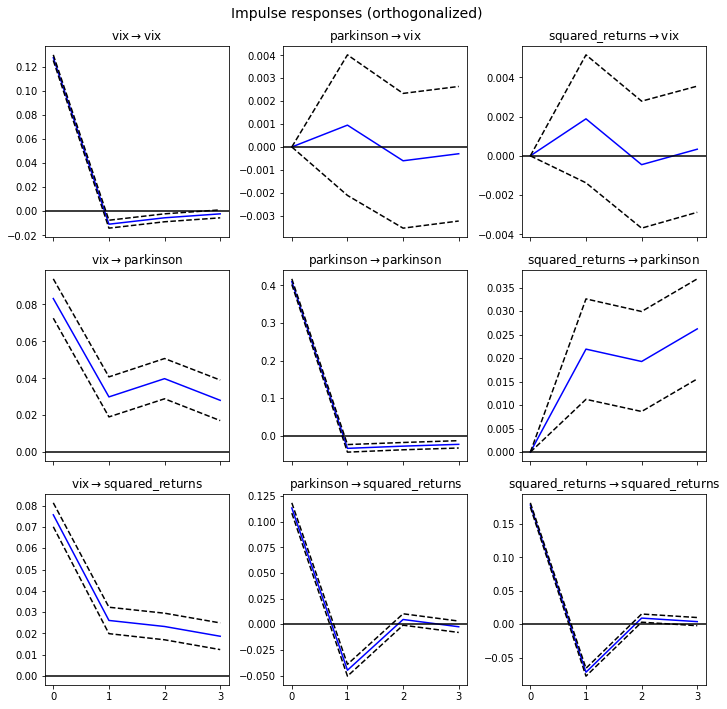

In [52]:
# Compute the impulse response function (IRF) for 3 periods
irf = model_fitted.irf(3)

# Plot the IRFs with orthogonalized shocks
irf.plot(orth=True)

# Adjust the layout of the plots for better readability
plt.tight_layout()


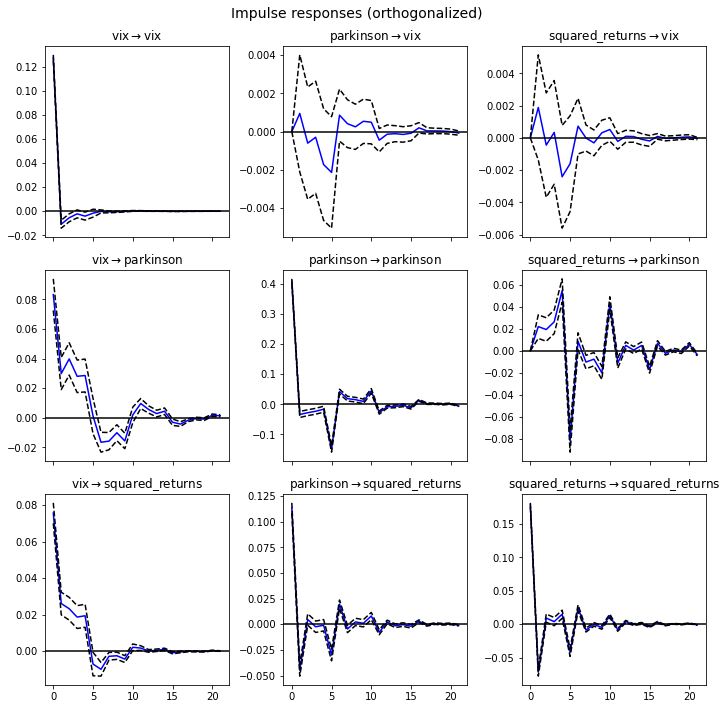

In [53]:
# Compute the impulse response function (IRF) for int(252/12)=21 periods
irf = model_fitted.irf(int(252/12))

# Plot the IRFs with orthogonalized shocks
irf.plot(orth=True)

# Adjust the layout of the plots for better readability
plt.tight_layout()


An Impulse Response Function (IRF) is a tool used to analyze a system's response to an external stimulus or "impulse." In the context of time series analysis and econometrics, IRFs are often employed to examine the dynamic effects of shocks on variables within a model.

Orthogonalized impulse response functions help to disentangle the effects of shocks by transforming the correlated shocks into a set of uncorrelated shocks (orthogonal shocks). This is done using a technique called the Cholesky decomposition. By setting orth=True, the function will orthogonalize the impulse response functions using the Cholesky decomposition, making the interpretation of the effects of shocks on the variables clearer.

Understanding these effects is crucial for volatility analysis, as investors can potentially capitalize on them. If one volatility measure impacts another, we can use the first as a proxy (e.g., when switching between daily and intraday values). More importantly, if squared returns lag Parkinson, we could predict return volatility and adjust our strategies accordingly.

We will now discuss the effects of each series on the others:

VIX: When squared returns and Parkinson are impacted, the VIX remains unaffected. Since the VIX is calculated over 30 days (21 periods in out case), sporadic impacts don't affect it in the medium term. However, a shock to the VIX could alter market sentiment, introducing uncertainty that affects both daily and intraday volatilities.

Parkinson: A shock to the VIX has a persistent and lagged impact on Parkinson, as the VIX shock has medium-term consequences, influencing the market for 10 to 15 days. Shocks to squared returns have significant repercussions on Parkinson. The effect is amplified, which is expected when considering the impact of daily changes on intraday measures. Consequently, intraday uncertainty is heightened.

Squared returns: The VIX has a lagged yet substantial effect, while Parkinson's impact diminishes over time but remains significant.

Comparing the confidence intervals over 3 days and 30 days, we can see that the VIX is minimally or not affected by the other series. In contrast, Parkinson almost immediately influences squared returns. This suggests that using Parkinson as a proxy for returns is viable and enables the conversion of daily return series to intraday series with statistical accuracy. It is well-known that investors pay close attention to the influence of the VIX in the markets, and everyone is mindful of its values. It is also referred to as the "fear index".

Note: We can draw parallels between these effects and physical phenomena, such as Mpemba effect or the surface tension of water.
